In [1]:
!nvidia-smi

Mon Apr  7 09:57:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.03             Driver Version: 572.60         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P3             13W /   55W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[Round 50] AUC: 0.94794 | Current LR: 0.30000
[Round 100] AUC: 0.95005 | Current LR: 0.30000
[Round 150] AUC: 0.95099 | Current LR: 0.30000
[Round 200] AUC: 0.95200 | Current LR: 0.30000
[Round 250] AUC: 0.95236 | Current LR: 0.30000
[Round 300] AUC: 0.95264 | Current LR: 0.30000
[Round 350] AUC: 0.95291 | Current LR: 0.30000
[Round 400] AUC: 0.95311 | Current LR: 0.30000
[Round 450] AUC: 0.95323 | Current LR: 0.30000

[Round 455] Reducing learning rate to 0.15000

[Round 467] Reducing learning rate to 0.07500

[Round 469] Early stopping. Best AUC was 0.95324 at round 464

Test Accuracy: 87.62%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87   1750755
         1.0       0.86      0.90      0.88   1749245

    accuracy                           0.88   3500000
   macro avg       0.88      0.88      0.88   3500000
weighted avg       0.88      0.88      0.88   3500000



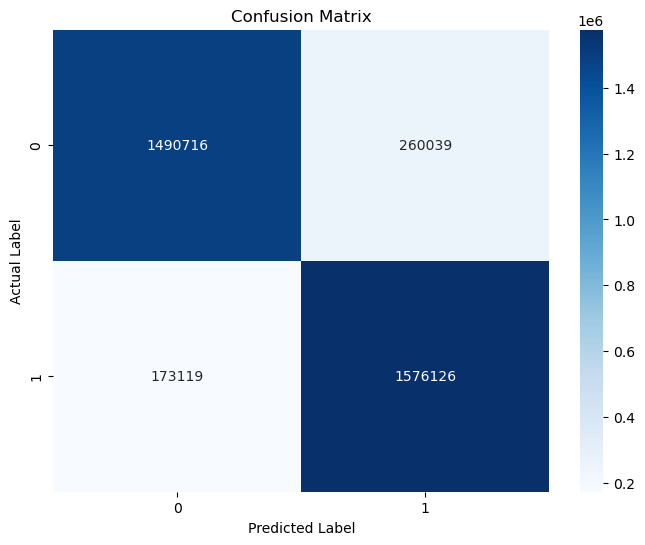

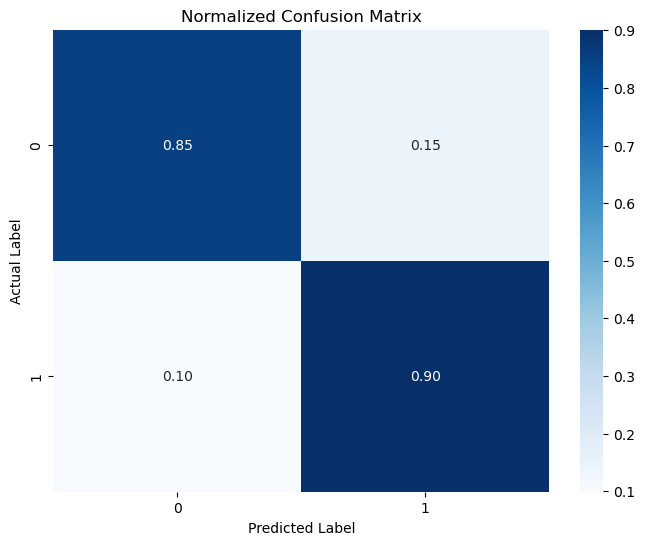

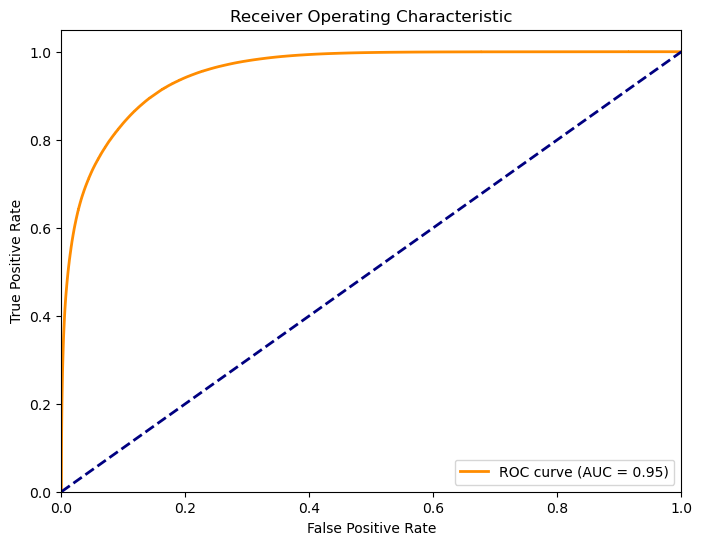

CPU times: user 7min 51s, sys: 3.68 s, total: 7min 55s
Wall time: 8min 7s


In [1]:
%%time
import cudf
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# -----------------------------
# Load pre-split datasets
# -----------------------------
all_train = cudf.read_csv("all_train.csv")
all_test = cudf.read_csv("all_test.csv")

# -----------------------------
# Separate features and labels
# -----------------------------
X_train = all_train.drop('# label', axis=1)
y_train = all_train['# label']
X_test = all_test.drop('# label', axis=1)
y_test = all_test['# label']

# -----------------------------
# Parameters
# -----------------------------
params = {
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': 'auc',
    'learning_rate': 0.3
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# -----------------------------
# Custom Callback: Reduce LR on Plateau + Early Stop + Verbose every 50 rounds
# -----------------------------
class ReduceLROnPlateauWithEarlyStop(xgb.callback.TrainingCallback):
    def __init__(self, reduce_patience=3, stop_patience=5, reduce_factor=0.5, verbose_every=50):
        self.best_score = -np.inf
        self.best_iter = 0
        self.wait = 0
        self.lr = params['learning_rate']
        self.reduce_patience = reduce_patience
        self.stop_patience = stop_patience
        self.reduce_factor = reduce_factor
        self.verbose_every = verbose_every

    def after_iteration(self, model, epoch, evals_log):
        current_score = evals_log['Test']['auc'][-1]

        if (epoch + 1) % self.verbose_every == 0:
            print(f"[Round {epoch+1}] AUC: {current_score:.5f} | Current LR: {self.lr:.5f}")

        if current_score > self.best_score:
            self.best_score = current_score
            self.best_iter = epoch
            self.wait = 0
        else:
            self.wait += 1

            if self.wait == self.reduce_patience:
                self.lr *= self.reduce_factor
                model.set_param('learning_rate', self.lr)
                print(f"\n[Round {epoch+1}] Reducing learning rate to {self.lr:.5f}")

            if self.wait >= self.stop_patience:
                print(f"\n[Round {epoch+1}] Early stopping. Best AUC was {self.best_score:.5f} at round {self.best_iter+1}")
                return True

        return False

# -----------------------------
# Train Model
# -----------------------------
callback = ReduceLROnPlateauWithEarlyStop(reduce_patience=3, stop_patience=5)

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtest, 'Test')],
    callbacks=[callback],
    verbose_eval=False
)

# -----------------------------
# Predictions & Evaluation
# -----------------------------
y_pred_prob = bst.predict(dtest)
y_test_pd = y_test.to_pandas()
y_pred_pd = pd.Series((y_pred_prob > 0.5).astype(int))

print("\nTest Accuracy: {:.2f}%".format(accuracy_score(y_test_pd, y_pred_pd) * 100))
print("\nClassification Report:")
print(classification_report(y_test_pd, y_pred_pd))

# Confusion Matrix
cm = confusion_matrix(y_test_pd, y_pred_pd)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Normalized Confusion Matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_pd, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
